# XGBoost GPU Benchmarks

In this notebook, we benchmark the latest version of [XGBoost](https://github.com/dmlc/xgboost), the well-known Kaggle-winning gradient boosting algorithm, and in particular, the [XGBoost GPU plugin](https://github.com/dmlc/xgboost/blob/master/plugin/updater_gpu/README.md).

In [1]:
## For comparison between 1 GPU and 1 CPU, we use only 1 CPU:
#numactl --physcpubind=0 -C 0 --cpunodebind=0 -N 0 -m 0 jupyter notebook

In [2]:
# First time only: install xgboost, and restart the kernel afterwards
#import os
#os.system("git clone https://github.com/dmlc/xgboost --recursive && cd xgboost && mkdir build && cd build && cmake .. -DPLUGIN_UPDATER_GPU=ON && make -j; make; cd ../python-package && sudo python3.6 setup.py install")

In [3]:
%matplotlib inline
import xgboost as xgb
import pandas as pd
import numpy as np
import scipy as sp
import os
import time
from sklearn import metrics

In [25]:
if True:
    ## Airline dataset
    ## https://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/airlines_all.05p.csv"
    path = "/data/airlines_all.05p.csv"
    target = "IsDepDelayed"
    trainrows=4000000
    drop_cols=['ArrTime','DepTime','ActualElapsedTime','AirTime','ArrDelay',
               'DepDelay','TaxiIn', 'TaxiOut', 'Cancelled',
               'CancellationCode', 'Diverted', 'CarrierDelay', 
              'WeatherDelay', 'NASDelay', 'SecurityDelay', 'TailNum',
              'LateAircraftDelay', 'IsArrDelayed']
    num_round = 100
    learn_rate = 0.02
    max_depth = 8
    num_class = 2

    ## Parse data into a Pandas Frame
    t_start = time.time()
    df = pd.read_csv(path,encoding= "ISO-8859-1")
    if drop_cols is not None:
        df = df.drop(drop_cols, axis=1)
    print("Time to parse by Pandas (sec): ", time.time() - t_start)

    df_target = df[target].replace(('YES', 'NO'), (1, 0))
    df = df.drop(target, axis=1)
    cols = df.columns.values
    df.shape

    from sklearn import preprocessing
    catcols = df.select_dtypes(include=['object'])
    cc = [x for x in list(catcols.columns)]
    for f in cc:
        df[f] = preprocessing.LabelEncoder().fit_transform(list(df[f].values))
if False:
    #https://s3.amazonaws.com/h2o-public-test-data/bigdata/laptop/higgs_head_2M.csv
    path = "/opt/higgs_head_2M.csv"
    trainrows=1800000
    num_class = 2
    num_round = 200
    learn_rate = 0.02
    max_depth = 6
    
    ## Parse data into a Pandas Frame
    df = pd.read_csv(path, header=None)
    df_target = df.iloc[:,0]
    df.drop(df.iloc[:,0], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (10,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time to parse by Pandas (sec):  11.362692832946777


In [29]:
cols = df.columns.values
df.shape

(5834763, 12)

In [30]:
train = df.iloc[:trainrows,:]
test  = df.iloc[trainrows:,:]

In [31]:
train_target = df_target.iloc[:trainrows]
test_target  = df_target.iloc[trainrows:]

In [32]:
print(train.shape)
print(test.shape)

(4000000, 12)
(1834763, 12)


In [33]:
!lscpu

Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                80
On-line CPU(s) list:   0-79
Thread(s) per core:    2
Core(s) per socket:    20
Socket(s):             2
NUMA node(s):          2
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 79
Model name:            Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
Stepping:              1
CPU MHz:               2201.000
CPU max MHz:           2201.0000
CPU min MHz:           1200.0000
BogoMIPS:              4391.41
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              51200K
NUMA node0 CPU(s):     0-19,40-59
NUMA node1 CPU(s):     20-39,60-79
Flags:                 fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc arch_perfmon pebs bts rep_good nopl xtop

In [34]:
!cat /proc/meminfo | grep MemTotal

MemTotal:       528278376 kB


In [35]:
!nvidia-smi -L

GPU 0: Tesla P100-SXM2-16GB (UUID: GPU-77864ed9-e817-3463-e5be-bf4c4c563a4c)
GPU 1: Tesla P100-SXM2-16GB (UUID: GPU-e8ece262-f677-038f-5b40-6cc86f978487)
GPU 2: Tesla P100-SXM2-16GB (UUID: GPU-7d996bf3-876b-1439-e447-ec8fb235fd98)
GPU 3: Tesla P100-SXM2-16GB (UUID: GPU-151287c0-bb97-6f82-fedb-a88273ee5447)
GPU 4: Tesla P100-SXM2-16GB (UUID: GPU-99c5cdb5-54b9-ccd2-eb51-a32850d37ebf)
GPU 5: Tesla P100-SXM2-16GB (UUID: GPU-d2d22332-f462-061e-606a-3d6a5ea89848)
GPU 6: Tesla P100-SXM2-16GB (UUID: GPU-5cc8b757-ee04-3bbb-5866-1f9f8c404a54)
GPU 7: Tesla P100-SXM2-16GB (UUID: GPU-3016922d-1da7-46cd-17f3-cb6b3ab17bc3)


In [36]:
def runXGBoost(param):
    have_updater = "updater" in param.keys()
    label = "XGBoost " \
        + ("GPU hist" if have_updater and param["updater"]=="grow_gpu_hist" else "GPU exact" if have_updater and param["updater"]=="grow_gpu" else "CPU") \
        + " " + (param["tree_method"] if "updater" not in param.keys() else "")
    print(label)
    print("=====================")
    for k, v in param.items():
        print(k, v)
    print("=====================")
    
    t_start = time.time()
    dtrain = xgb.DMatrix(train.values, label = train_target.values, feature_names=[str(c) for c in cols])
    dtest  = xgb.DMatrix(test.values,  label = test_target.values,  feature_names=[str(c) for c in cols])
    tt = time.time() - t_start
    print("Time to create DMatrix (sec): ", tt)
    dmatrix_times.append(tt)
    
    t_start = time.time()
    bst = xgb.train(param, dtrain, num_round)
    tt = time.time() - t_start
    print("Time to train (sec): ", tt)
    train_times.append(tt)

    t_start = time.time()
    preds = bst.predict(dtest)
    tt = time.time() - t_start
    print("Time to predict (sec): ", tt)
    score_times.append(tt)

    labels = dtest.get_label()
    auc = metrics.roc_auc_score(labels, preds)
    print("AUC:", auc)
    valid_aucs.append(auc)
    plot_labels.append(label)
    
    fs = bst.get_fscore()
    
    # Optional: Uncomment to show variable importance
    #varimp = pd.DataFrame({'Importance': list(fs.values()), 'Feature': list(fs.keys())})
    #varimp.sort_values(by = 'Importance', inplace = True, ascending = False)
    #varimp.head(10).plot(label='importance',kind="barh",x="Feature",y="Importance").invert_yaxis()

In [37]:
valid_aucs = []
dmatrix_times = []
train_times = []
score_times = []
plot_labels = []

In [38]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU exact
objective reg:logistic
max_depth 8
eta 0.02
tree_method exact
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  2.6406610012054443
Time to train (sec):  169.11206078529358
Time to predict (sec):  0.6017725467681885
AUC: 0.643891977635


In [39]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"approx"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU approx
objective reg:logistic
max_depth 8
eta 0.02
tree_method approx
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  2.508355140686035
Time to train (sec):  105.81683373451233
Time to predict (sec):  0.5396466255187988
AUC: 0.642983039293


In [40]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"hist"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost CPU hist
objective reg:logistic
max_depth 8
eta 0.02
tree_method hist
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  2.546616315841675
Time to train (sec):  36.08783721923828
Time to predict (sec):  0.5337545871734619
AUC: 0.64266735882


In [41]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "updater":"grow_gpu"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost GPU exact 
objective reg:logistic
max_depth 8
eta 0.02
tree_method exact
updater grow_gpu
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  2.511988878250122
Time to train (sec):  21.74807620048523
Time to predict (sec):  0.5173437595367432
AUC: 0.64173550419


In [42]:
param = {
    "objective":('reg:logistic' if num_class>1 else 'reg:linear')
    , "max_depth":max_depth
    , "eta":learn_rate
    , "tree_method":"exact"
    , "updater":"grow_gpu_hist"
    , "subsample":0.7
    , "colsample_bytree":0.9
    , "min_child_weight":5
    , "seed":12345
}
runXGBoost(param)

XGBoost GPU hist 
objective reg:logistic
max_depth 8
eta 0.02
tree_method exact
updater grow_gpu_hist
subsample 0.7
colsample_bytree 0.9
min_child_weight 5
seed 12345
Time to create DMatrix (sec):  2.4832777976989746
Time to train (sec):  9.643814325332642
Time to predict (sec):  0.5504333972930908
AUC: 0.638979765148


In [43]:
data = pd.DataFrame({'algorithm'  :plot_labels,
                     'dmatrix time':dmatrix_times,
                     'training time':train_times,
                     'scoring time':score_times,
                     'validation AUC' :valid_aucs}).sort_values(by="training time")
data

,algorithm,dmatrix time,scoring time,training time,validation AUC
4,XGBoost GPU hist,2.483278,0.550433,9.643814,0.638980
3,XGBoost GPU exact,2.511989,0.517344,21.748076,0.641736
2,XGBoost CPU hist,2.546616,0.533755,36.087837,0.642667
1,XGBoost CPU approx,2.508355,0.539647,105.816834,0.642983
0,XGBoost CPU exact,2.640661,0.601773,169.112061,0.643892


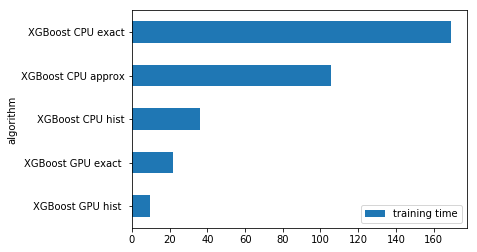

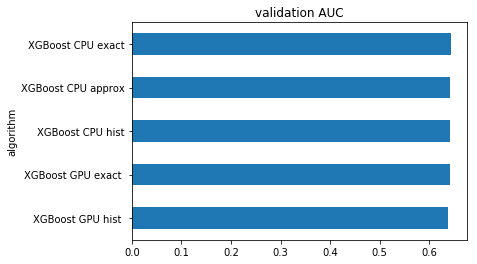

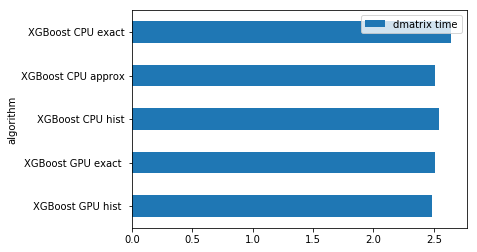

In [44]:
data.plot(label="training time",kind='barh',x='algorithm',y='training time')
data.plot(title="validation AUC",kind='barh',x='algorithm',y='validation AUC',legend=False)
data.plot(label="dmatrix time",kind='barh',x='algorithm',y='dmatrix time')